# We're trying to predict the ordinal variable damage_grade, which represents a level of damage to the building that was hit by the earthquake. There are 3 grades of the damage:

1. represents low damage
2. represents a medium amount of damage
3. represents almost complete destruction

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve, auc, classification_report, average_precision_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
X_train = pd.read_csv('/Users/apple/5243AppliedDS/Modeling-Earthquake-Damage-main/Resources/Datasets/X_train.csv')
y_train = pd.read_csv('/Users/apple/5243AppliedDS/Modeling-Earthquake-Damage-main/Resources/Datasets/y_train.csv')
X_test = pd.read_csv('/Users/apple/5243AppliedDS/Modeling-Earthquake-Damage-main/Resources/Datasets/X_test.csv')
y_test = pd.read_csv('/Users/apple/5243AppliedDS/Modeling-Earthquake-Damage-main/Resources/Datasets/y_test.csv')
y_train = y_train['damage_grade']
y_test = y_test['damage_grade']

In [3]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
X_train_pca = X_train_scaled
X_test_pca = X_test_scaled

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Initialize the classifier
dtc = DecisionTreeClassifier()

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=dtc, param_grid=param_grid, cv=50, scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(X_train_pca, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameter: {best_params}")
print(f"Best Score: {best_score}")


Best Parameter: {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Score: 0.6833797006907137


In [6]:
# use the best parameters to fit the model
decision_tree_clf = DecisionTreeClassifier(**best_params)
decision_tree_clf.fit(X_train_pca, y_train)
# decision_tree_clf = DecisionTreeClassifier(random_state=42)
# decision_tree_clf.fit(X_train_pca, y_train)

DecisionTreeClassifier(max_depth=10)

In [7]:
y_pred = decision_tree_clf.predict(X_test_pca)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("F1 Score (Weighted):", f1_score(y_test, y_pred, average='weighted'))
print("Precision Score (Weighted):", precision_score(y_test, y_pred, average='weighted'))
print("Recall Score (Weighted):", recall_score(y_test, y_pred, average='weighted'))

y_pred_proba = grid_search.best_estimator_.predict_proba(X_test)
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted'))

              precision    recall  f1-score   support

           1       0.61      0.40      0.49      5025
           2       0.69      0.81      0.75     29652
           3       0.68      0.55      0.61     17444

    accuracy                           0.69     52121
   macro avg       0.66      0.59      0.61     52121
weighted avg       0.68      0.69      0.68     52121

[[ 2023  2924    78]
 [ 1214 24011  4427]
 [   71  7694  9679]]
Accuracy Score: 0.6851940676502754
F1 Score (Weighted): 0.6766641737245677
Precision Score (Weighted): 0.6818109813489703
Recall Score (Weighted): 0.6851940676502754
ROC AUC Score: 0.4907022935804168


/Users/apple/anaconda3/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [8]:
# result_df = pd.read_csv('../Resources/Datasets/results.csv', index_col=0)
# result_df.loc['Decision Tree'] = [accuracy_score(y_test, y_pred), 
#                                    precision_score(y_test, y_pred, average='weighted'), 
#                                    recall_score(y_test, y_pred, average='weighted'), 
#                                    f1_score(y_test, y_pred, average='weighted'), 
#                                    roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted'), 
#                                    average_precision_score(y_test, y_pred_proba, average='weighted')]
# result_df

,accuracy,precision,recall,weighted_f1_score,AUC,AP
Model,,,,,,
Decision Tree,0.685194,0.681811,0.685194,0.676664,0.490702,0.441517
Random Forest,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
XGB,0.735078,0.736393,0.735078,0.727481,0.834599,0.790500
SVM,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
KNN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Logistic Regression,0.591988,0.580377,0.591988,0.539761,0.661276,0.586349
Neural Network,0.656300,0.655297,0.656300,0.638502,0.735512,0.669619
Naive Bayes,0.563765,0.551739,0.563765,0.553645,0.628271,0.545745
Preprocessed + XGB,0.666161,0.666032,0.666161,0.648679,0.756515,0.697251


In [9]:
# result_df.to_csv('../Resources/Datasets/results.csv')

In [10]:
# save the model using pickle
import pickle
filename = '../Models/decision_tree_model.pkl'
pickle.dump(decision_tree_clf, open(filename, 'wb'))

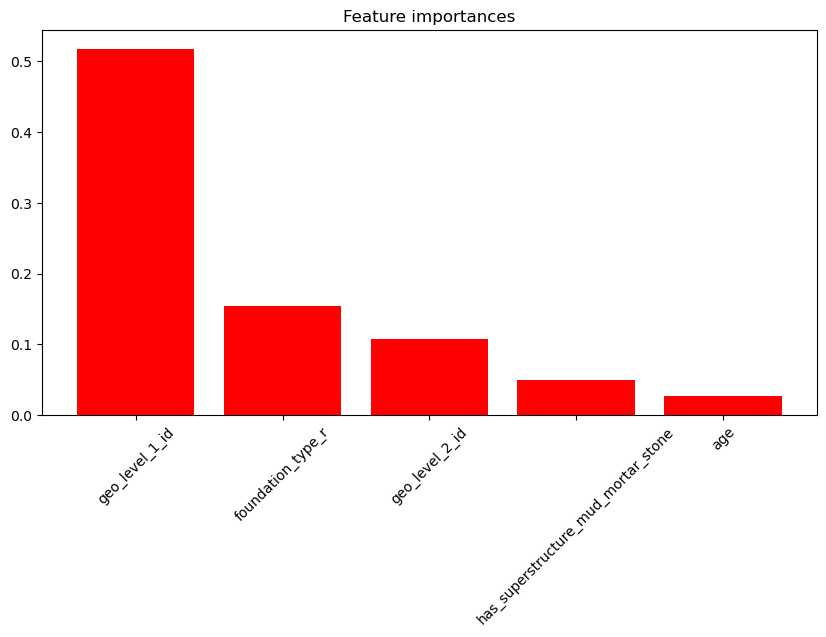

In [11]:
# find the top 5 important features
importances = decision_tree_clf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train.columns
plt.figure(figsize=(10, 5))
plt.title("Feature importances")
plt.bar(range(5), importances[indices[:5]], color="r", align="center")
plt.xticks(range(5), features[indices[:5]], rotation=45)
plt.show()

/var/folders/50/6g30f9493n9b0mlh03m6xhbh0000gn/T/ipykernel_27096/4108563088.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_features['damage_grade'] = y_train


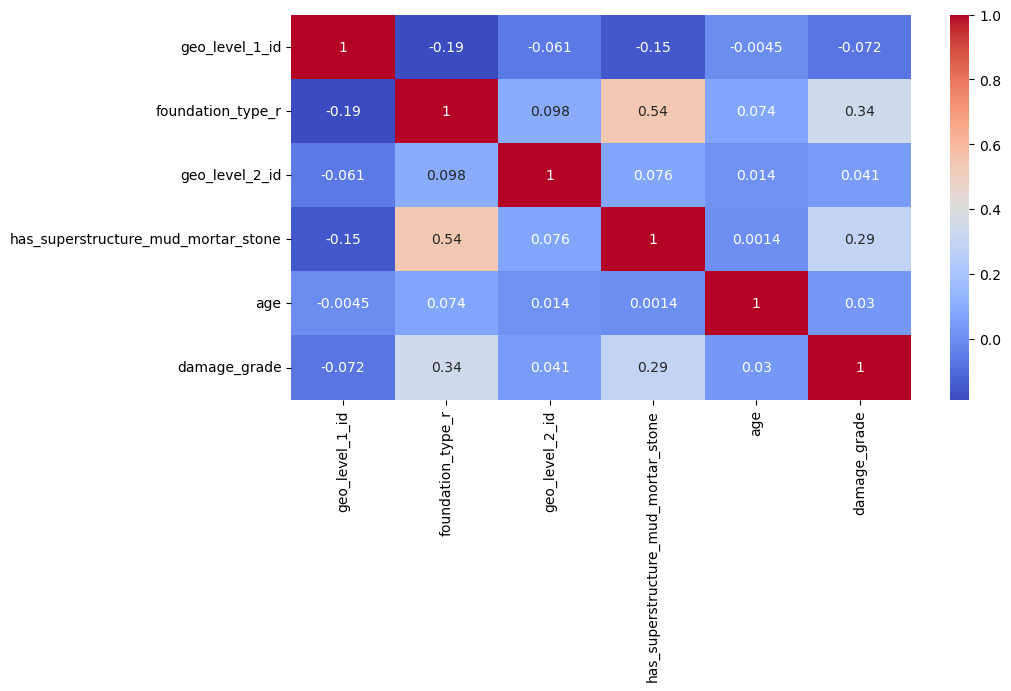

In [12]:
# finding the relationship of the top 5 important features and demage level
top_10_features = features[indices[:5]]
top_10_features = X_train[top_10_features]
top_10_features['damage_grade'] = y_train
plt.figure(figsize=(10, 5))
sns.heatmap(top_10_features.corr(), annot=True, cmap='coolwarm')
plt.show()


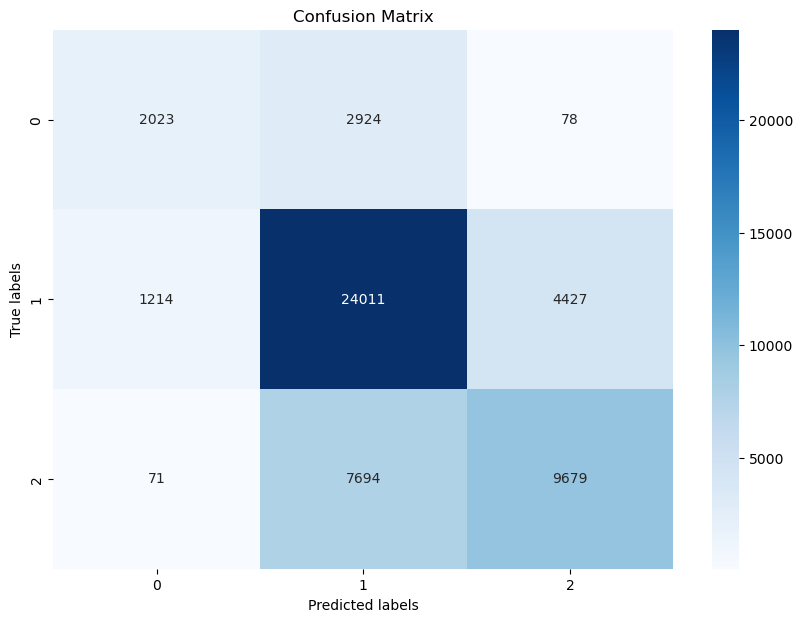

In [13]:
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [14]:
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted'))
# get the roc curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_proba[:, i], pos_label=i+1)
    roc_auc[i] = auc(fpr[i], tpr[i])
roc_auc

ROC AUC Score: 0.4907022935804168


{0: 0.5025420037573303, 1: 0.49004138438632516, 2: 0.48841513099065637}

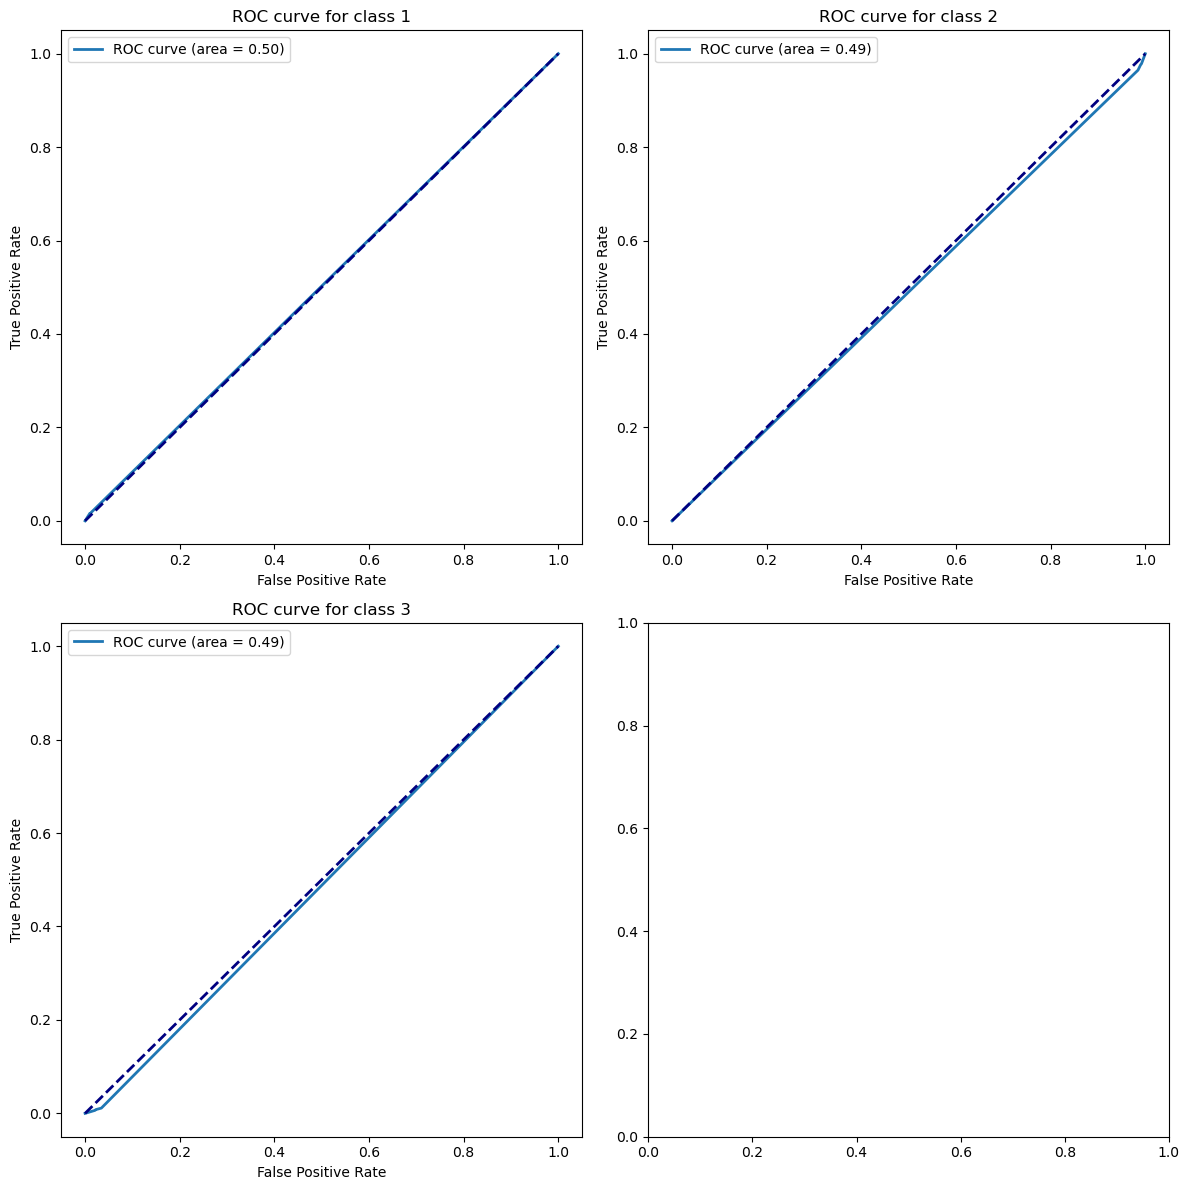

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))  # Creates a 2x2 grid of Axes objects
axs = axs.ravel()  # Ravel turns a matrix into a vector, which is easier to iterate
for i in range(3):
    axs[i].plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = %0.2f)' % roc_auc[i])
    axs[i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axs[i].set_title('ROC curve for class {}'.format(i+1))
    axs[i].set_xlabel('False Positive Rate')
    axs[i].set_ylabel('True Positive Rate')
    axs[i].legend(loc='best')

plt.tight_layout()
plt.show()


### Modify data to be more balanced

In [16]:
# create a balanced dataset
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)
class_counts = train['damage_grade'].value_counts()
test_class_counts = test['damage_grade'].value_counts()
min_class_count = class_counts.min()
min_class_test_count = test_class_counts.min()
# Use DataFrame.groupby and sample to resample each class
balanced_train = train.groupby('damage_grade').apply(lambda x: x.sample(min_class_count))
balanced_test = test.groupby('damage_grade').apply(lambda x: x.sample(min_class_test_count))
balanced_train = balanced_train.reset_index(drop=True)
balanced_test = balanced_test.reset_index(drop=True)

# shuffle the dataset
balanced_train = balanced_train.sample(frac=1)
balanced_test = balanced_test.sample(frac=1)

# drop the last column for X_train and the last colomn for y_train
balanced_X_train = balanced_train.drop('damage_grade', axis=1)
balenced_X_test = balanced_test.drop('damage_grade', axis=1)
balanced_y_train = balanced_train['damage_grade']
balanced_y_test = balanced_test['damage_grade']
balenced_X_test



,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,...,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
11642,402600,6,706,3723,1,20,8,2,0,1,...,False,False,False,False,False,False,False,False,True,False
3246,384598,26,39,633,2,5,26,7,0,0,...,False,False,False,False,False,False,False,False,True,False
1416,860353,26,886,12157,2,20,5,5,0,0,...,False,False,False,False,False,False,False,False,True,False
12694,939970,8,1009,6323,2,15,12,6,0,1,...,False,False,False,False,False,False,False,False,True,False
5622,970213,12,650,7784,1,45,4,3,0,1,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9048,660597,27,181,2607,4,30,7,9,1,0,...,False,False,False,False,False,False,False,False,True,False
9976,551785,17,1183,3257,2,10,8,6,0,0,...,False,False,False,False,False,True,False,False,True,False
6974,417323,27,533,1424,3,35,15,9,1,0,...,False,False,False,False,False,False,False,False,True,False
11557,231507,27,269,5197,3,40,6,7,0,1,...,False,False,False,False,False,False,False,False,True,False


In [17]:
scaler = StandardScaler()
balanced_X_train_scaled = scaler.fit_transform(balanced_X_train)
balenced_X_test_scaled = scaler.transform(balenced_X_test)

In [18]:
pca = PCA(n_components=0.95)  # Adjust n_components
# balanced_X_train_pca = pca.fit_transform(balanced_X_train_scaled)
# balenced_X_test_pca = pca.transform(balenced_X_test_scaled)
balanced_X_train_pca = balanced_X_train_scaled
balenced_X_test_pca = balenced_X_test_scaled
# len(balenced_X_test_pca[0])
# # check what is the best number of components
# pca = PCA()
# pca.fit(balanced_X_train_scaled)
# cumsum = np.cumsum(pca.explained_variance_ratio_)
# d = np.argmax(cumsum >= 0.95) + 1
# d

In [19]:
balenced_decision_tree_clf = DecisionTreeClassifier(random_state=42)
balenced_decision_tree_clf.fit(balanced_X_train_pca, balanced_y_train)

DecisionTreeClassifier(random_state=42)

In [20]:
y_pred = balenced_decision_tree_clf.predict(balenced_X_test_pca)
print(classification_report(balanced_y_test, y_pred))

              precision    recall  f1-score   support

           1       0.73      0.72      0.73      5025
           2       0.50      0.50      0.50      5025
           3       0.64      0.65      0.65      5025

    accuracy                           0.62     15075
   macro avg       0.62      0.62      0.62     15075
weighted avg       0.62      0.62      0.62     15075



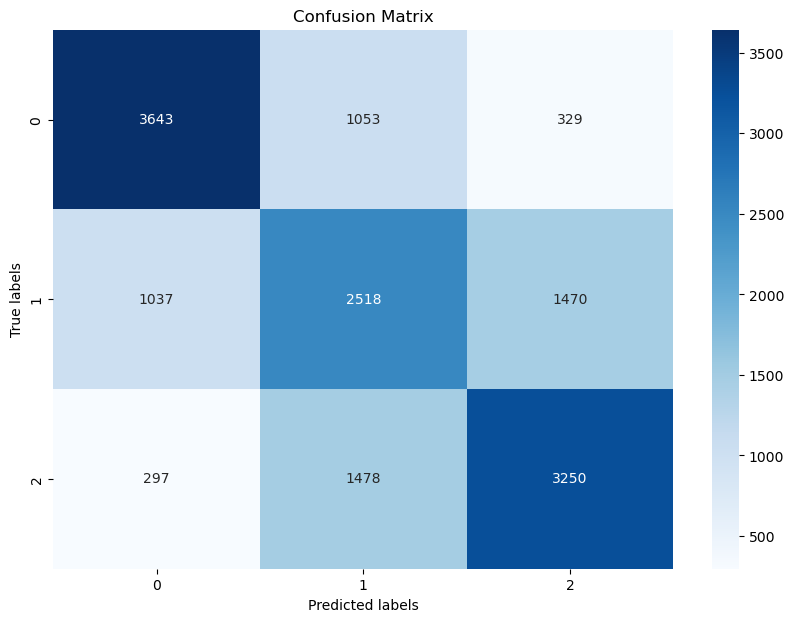

In [21]:
cm = confusion_matrix(balanced_y_test, y_pred)

# Plot the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [22]:
y_test_auc = pd.get_dummies(balanced_y_test)
y_pred_auc = pd.get_dummies(y_pred)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_auc.iloc[:, i], y_pred_auc.iloc[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
roc_auc

{0: 0.7961194029850746, 1: 0.6246268656716417, 2: 0.7338805970149254}

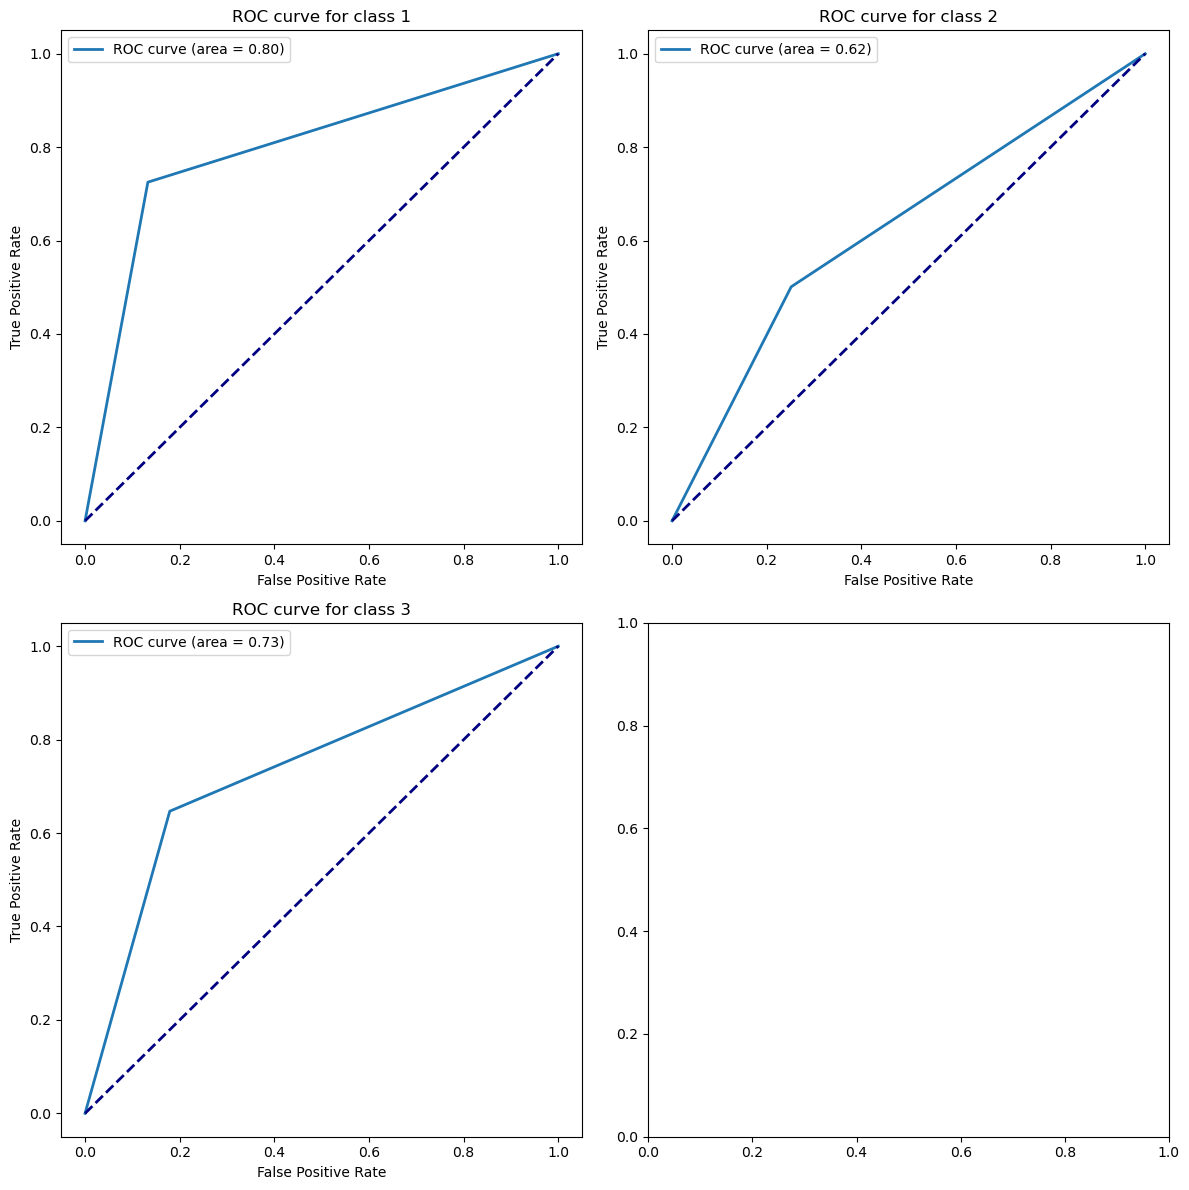

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))  # Creates a 2x2 grid of Axes objects
axs = axs.ravel()  # Ravel turns a matrix into a vector, which is easier to iterate
for i in range(3):
    axs[i].plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = %0.2f)' % roc_auc[i])
    axs[i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axs[i].set_title('ROC curve for class {}'.format(i+1))
    axs[i].set_xlabel('False Positive Rate')
    axs[i].set_ylabel('True Positive Rate')
    axs[i].legend(loc='best')

plt.tight_layout()
plt.show()


### Use Preprocessing data to train and test model

In [25]:
# Load the datasets
X_train = pd.read_csv('/Users/apple/Desktop/drive-download-20240305T032759Z-001/X_train_processed.csv', header = None)
y_train = pd.read_csv('/Users/apple/Desktop/drive-download-20240305T032759Z-001/y_train_processed.csv')
X_test = pd.read_csv('/Users/apple/Desktop/drive-download-20240305T032759Z-001/X_test_processed.csv', header = None)
y_test = pd.read_csv('/Users/apple/Desktop/drive-download-20240305T032759Z-001/y_test_processed.csv')

X_train.head(), y_train.head(), X_test.head(), y_test.head()

if isinstance(y_train, pd.DataFrame):
    y_train = y_train['damage_grade']
if isinstance(y_test, pd.DataFrame):
    y_test = y_test['damage_grade']

y_train = y_train.squeeze()
y_test = y_test.squeeze()
y_train

0         3
1         3
2         2
3         2
4         2
         ..
208475    2
208476    2
208477    3
208478    3
208479    2
Name: damage_grade, Length: 208480, dtype: int64

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Initialize the classifier
dtc = DecisionTreeClassifier()

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=dtc, param_grid=param_grid, cv=50, scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameter: {best_params}")
print(f"Best Score: {best_score}")


Best Parameter: {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5}
Best Score: 0.6122746939411772


In [27]:
# use the best parameters to fit the model
decision_tree_clf = DecisionTreeClassifier(**best_params)
decision_tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5)

In [28]:
y_pred = decision_tree_clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("F1 Score (Weighted):", f1_score(y_test, y_pred, average='weighted'))
print("Precision Score (Weighted):", precision_score(y_test, y_pred, average='weighted'))
print("Recall Score (Weighted):", recall_score(y_test, y_pred, average='weighted'))

y_pred_proba = grid_search.best_estimator_.predict_proba(X_test)
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted'))

              precision    recall  f1-score   support

           1       0.55      0.33      0.41      5025
           2       0.62      0.84      0.72     29652
           3       0.59      0.31      0.41     17444

    accuracy                           0.61     52121
   macro avg       0.59      0.49      0.51     52121
weighted avg       0.61      0.61      0.58     52121

[[ 1659  3165   201]
 [ 1217 24870  3565]
 [  141 11840  5463]]
Accuracy Score: 0.6138024980334222
F1 Score (Weighted): 0.5838718512164718
Precision Score (Weighted): 0.6059528016391118
Recall Score (Weighted): 0.6138024980334222
ROC AUC Score: 0.6817292780712169


In [31]:
result_df = pd.read_csv('../Resources/Datasets/results.csv', index_col=0)
result_df.loc['Decision Tree'] = [accuracy_score(y_test, y_pred), 
                                   precision_score(y_test, y_pred, average='weighted'), 
                                   recall_score(y_test, y_pred, average='weighted'), 
                                   f1_score(y_test, y_pred, average='weighted'), 
                                   roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted'), 
                                   average_precision_score(y_test, y_pred_proba, average='weighted')]
result_df

,accuracy,precision,recall,weighted_f1_score,AUC,AP
Model,,,,,,
Decision Tree,0.613802,0.605953,0.613802,0.583872,0.681729,0.600049
Random Forest,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
XGB,0.735078,0.736393,0.735078,0.727481,0.834599,0.790500
SVM,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
KNN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Logistic Regression,0.591988,0.580377,0.591988,0.539761,0.661276,0.586349
Neural Network,0.656300,0.655297,0.656300,0.638502,0.735512,0.669619
Naive Bayes,0.563765,0.551739,0.563765,0.553645,0.628271,0.545745
Preprocessed + XGB,0.666161,0.666032,0.666161,0.648679,0.756515,0.697251


In [32]:
result_df.to_csv('../Resources/Datasets/results.csv')